In [101]:
import os
import keras
from keras.models import Sequential,load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [102]:
data_dir = pathlib.Path('../input/cell-images-for-detecting-malaria/cell_images/cell_images')
X = []
y = []
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for file in os.listdir(label_dir):
            if file.endswith('.png'):
                img = Image.open(os.path.join(label_dir, file))
                img = img.convert('RGB')
                img = img.resize((50,50))
                X.append(np.array(img))
                y.append(label)

In [103]:
X,y=np.array(X),np.array(y)

In [104]:
X.shape

(27558, 50, 50, 3)

In [105]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [107]:

# Create an ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Augment the images and labels
augmented_images = []
augmented_labels = []

for i in range(len(X_train)):
    image = X_train[i]
    label = y_train[i]

    # Reshape the image to (1, height, width, channels) for flow
    image = image.reshape((1,) + image.shape)

    # Generate augmented images and labels
    for batch in datagen.flow(image, batch_size=1):
        augmented_images.append(batch[0])
        augmented_labels.append(label)
        break  # Ensure only one augmented image is generated

# Convert the lists to NumPy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)


In [108]:
X_train=np.concatenate((X_train,augmented_images),axis=0)
y_train=np.concatenate((y_train,augmented_labels),axis=0)
X_train.shape,y_train.shape

((35272, 50, 50, 3), (35272,))

In [109]:
print("Number of training samples:", len(X_train))
print("Number of validation samples:", len(X_val))
print("Number of testing samples:", len(X_test))

Number of training samples: 35272
Number of validation samples: 4410
Number of testing samples: 5512


In [110]:
# Initialize a Sequential model
model = Sequential()

# 1st layer or Input layer
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', input_shape=(50, 50, 3)))
model.add(MaxPooling2D((2, 2)))

# 2nd layer
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# 3rd layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))


# Flattening
model.add(Flatten())

# Last connection
model.add(Dense(128, activation='relu'))

# For Binary Classification
model.add(Dense(1, activation='sigmoid'))


In [111]:
model.compile(loss = "binary_crossentropy", optimizer='Adamax',metrics=['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 48, 48, 128)       3584      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 24, 24, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 22, 22, 64)        73792     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 11, 11, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 9, 9, 32)          18464     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 4, 4, 32)         

In [112]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/30
1103/1103 [==============================] - 9s 6ms/step - loss: 0.7207 - accuracy: 0.6491 - val_loss: 0.3955 - val_accuracy: 0.8281
Epoch 2/30
1103/1103 [==============================] - 6s 6ms/step - loss: 0.3386 - accuracy: 0.8666 - val_loss: 0.2699 - val_accuracy: 0.9272
Epoch 3/30
1103/1103 [==============================] - 6s 5ms/step - loss: 0.2770 - accuracy: 0.9004 - val_loss: 0.1881 - val_accuracy: 0.9399
Epoch 4/30
1103/1103 [==============================] - 6s 5ms/step - loss: 0.2453 - accuracy: 0.9106 - val_loss: 0.1921 - val_accuracy: 0.9370
Epoch 5/30
1103/1103 [==============================] - 6s 5ms/step - loss: 0.2258 - accuracy: 0.9189 - val_loss: 0.1596 - val_accuracy: 0.9526
Epoch 6/30
1103/1103 [==============================] - 6s 6ms/step - loss: 0.2125 - accuracy: 0.9226 - val_loss: 0.1566 - val_accuracy: 0.9540
Epoch 7/30
1103/1103 [==============================] - 6s 5ms/step - loss: 0.2050 - accuracy: 0.9266 - val_loss: 0.1515 - val_accuracy:

In [113]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 48, 48, 128)       3584      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 24, 24, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 22, 22, 64)        73792     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 11, 11, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 9, 9, 32)          18464     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 4, 4, 32)         

In [114]:
model_path = 'malaria_model.keras'
model.save(model_path)
print("Saved model to disk")

Saved model to disk


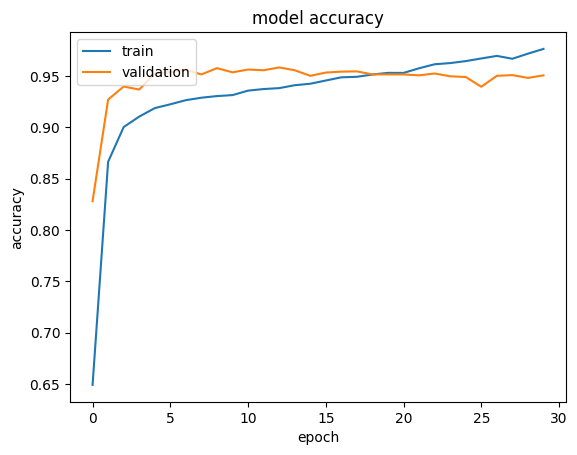

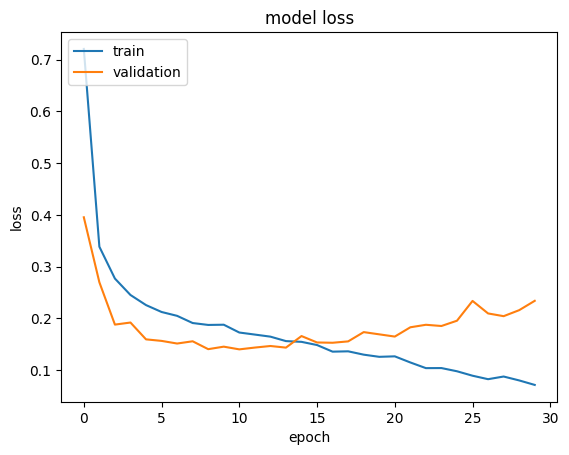

In [115]:
# summarize history for accuracy  

# plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

 # summarize history for loss  
   
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

173/173 [==============================] - 0s 2ms/step


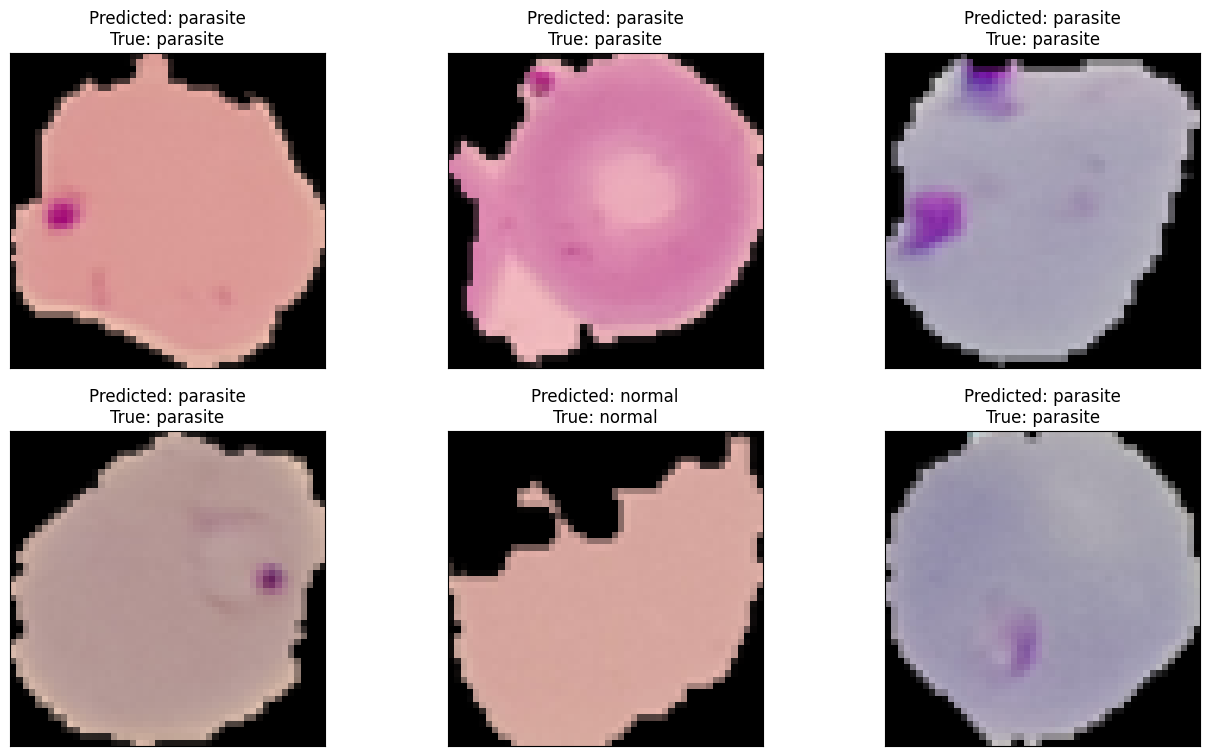

In [116]:
# Get predicted labels for test set
y_pred = model.predict(X_test)

# Define a list of class names for reference
class_names = ['parasite', 'normal']

# Plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=6, replace=False)):
    ax = fig.add_subplot(2, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_prob = y_pred[idx][0]
    pred_label = class_names[int(round(pred_prob))]
    true_label = class_names[int(y_test[idx])]
    ax.set_title("Predicted: {}\nTrue: {}".format(pred_label, true_label))

In [117]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(X_test)
threshold = 0.65
predictions_final = [int(pred>threshold) for pred in predictions]

print(classification_report(y_test, predictions_final))

173/173 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2715
           1       0.95      0.95      0.95      2797

    accuracy                           0.95      5512
   macro avg       0.95      0.95      0.95      5512
weighted avg       0.95      0.95      0.95      5512



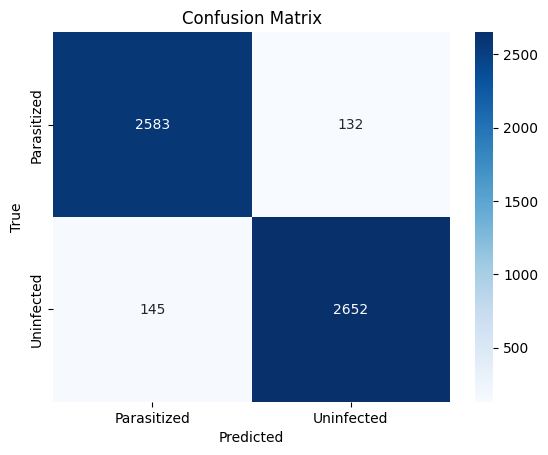

In [118]:
def plot_confusion_matrix(conf_matx, classes):
    sns.heatmap(conf_matx, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

conf_matx = confusion_matrix(y_test, predictions_final)
plot_confusion_matrix(conf_matx,label_encoder.classes_)

In [119]:
from sklearn import metrics
print("Accuracy = ",metrics.accuracy_score(y_test,predictions_final))

Accuracy =  0.9497460087082729
